In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import itertools
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [float(e) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till)
        m = sum(elems) / len(elems)
        yield m

/tmp/ipykernel_71445/4087695320.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def make_gemm_graph(ax, basedir, title, show_caches=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote_hbm_remote_hbm_remote')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    memories = [
        'ddr',
        'hbm',
        'ddr_remote',
        'hbm_remote',
    ]
    formats = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']


    results = [(list(results_generator(l, basedir + f'/{a}_{b}_{c}', skip=1)), f'{a}*{b}={c}') for a, b, c in itertools.product(memories, memories, ['hbm'])]

    ax.set_xscale('log', base=2)
    ax.set_title(title)
    ax.set_xlabel('Per matrix size (bytes)')
    ax.set_ylabel('Throughput to out matrix (GB/s)')
    for (r, l), f in zip(results, formats):
        ax.plot(numerical, r, f, label=l)
    if show_caches:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type')

def make_gemm_heatmap(ax, basedir, title, dest_memory):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote_hbm_remote_hbm_remote')]
    numerical.sort()
    print(numerical[-1])
    l = [str(dir) for dir in numerical]

    memories = [
        'hbm',
        'ddr',
        'hbm_remote',
        'ddr_remote',
    ]

    labels = ['HBM', 'DDR', 'Remote HBM', 'Remote DDR']

    data = np.zeros((4, 4))

    for i in range(4):
        for j in range(4):
            data[i, j] = list(results_generator(l, basedir + f'/{memories[i]}_{memories[j]}_{dest_memory}', skip=1))[-1]

    sns.heatmap(data, annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels, linewidths=1, square=True, cmap='Greens', ax=ax)
    ax.set(title=title, xlabel="Matrix B", ylabel="Matrix A")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

def make_read_write_graph(ax, basedir, title, scalability=False, n_threads=1, rng=None, latency=False, show_caches=True, show_cpu=True, show_gpu=True, remote=False, skip=1):
    if remote:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote')]
    else:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm')]
    numerical.sort()
    if rng is not None:
        numerical = numerical[rng[0]:rng[1]]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=skip))
    results2 = list(results_generator(l, basedir + '/hbm', skip=skip))
    if remote:
        results3 = list(results_generator(l, basedir + '/ddr_remote', skip=skip))
        results4 = list(results_generator(l, basedir + '/hbm_remote', skip=skip))
    #results3 = list(results_generator(l, basedir + '/mmio', skip=0, till=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    if latency:
        ax.set_ylabel('Latency (ns)')
    else:
        ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR')
    ax.plot(numerical, results2, 'x', label='HBM')
    if remote:
        ax.plot(numerical, results3, 's', label='DDR Remote')
        ax.plot(numerical, results4, '^', label='HBM Remote')
    #ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability and show_caches:
        if show_cpu:
            if n_threads > 1:
                ax.axvline(x=65536*n_threads, linestyle=(0, (1, 10)), label = f'CPU L1 x {n_threads}')
                ax.axvline(x=1048576*n_threads, linestyle=(0, (3, 10, 1, 10)), label = f'CPU L2 x {n_threads}')
            ax.axvline(x=65536, ls=':', label = f'CPU L1')
            ax.axvline(x=1048576, ls='-.', label = f'CPU L2')
            ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        if show_gpu:
            ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
            ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

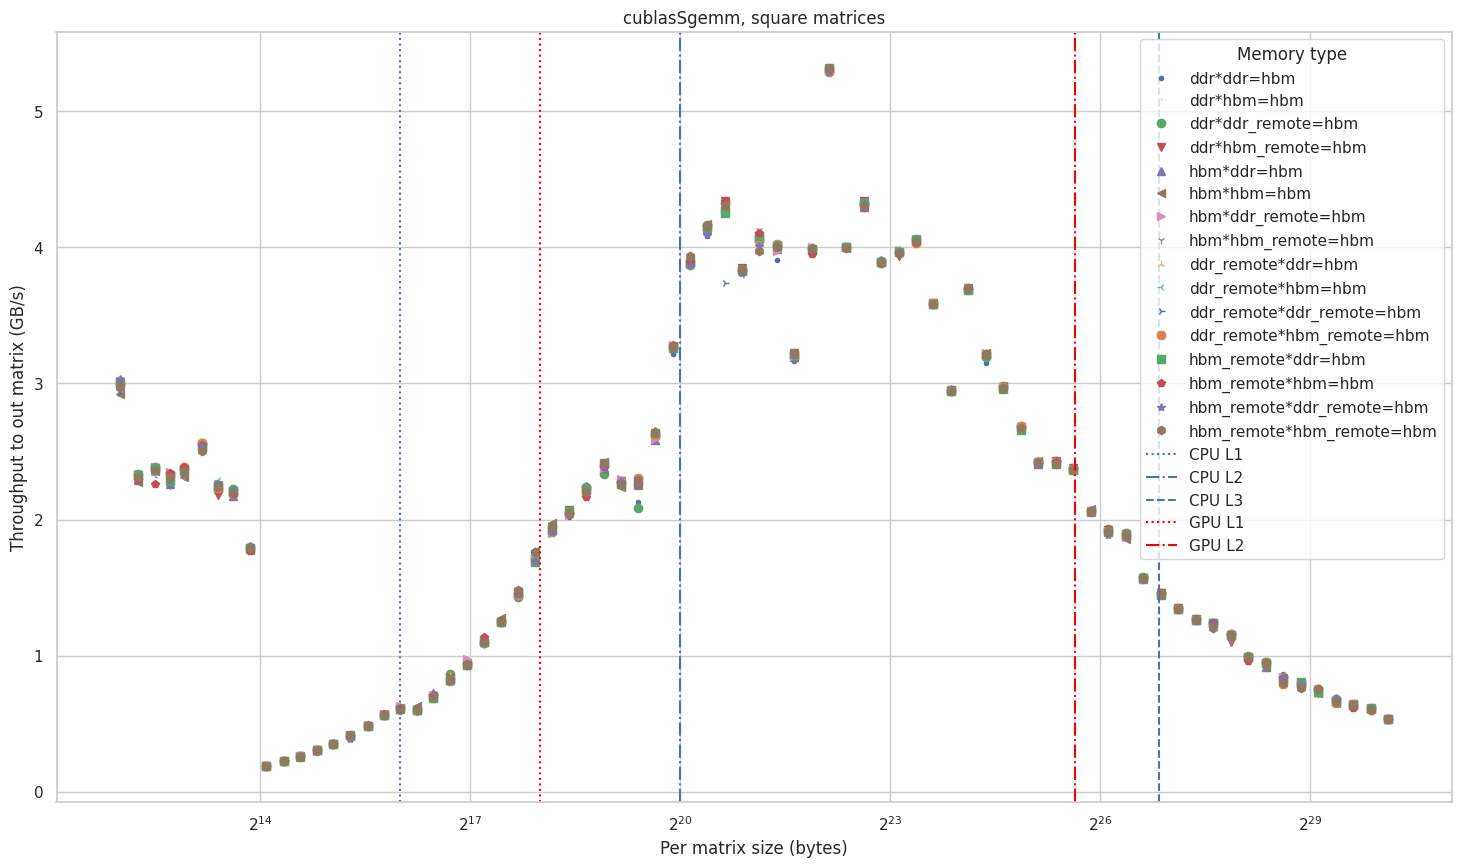

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
make_gemm_graph(ax, 'results/apps/gemm/openblas/', 'cublasSgemm, square matrices')

4294967296


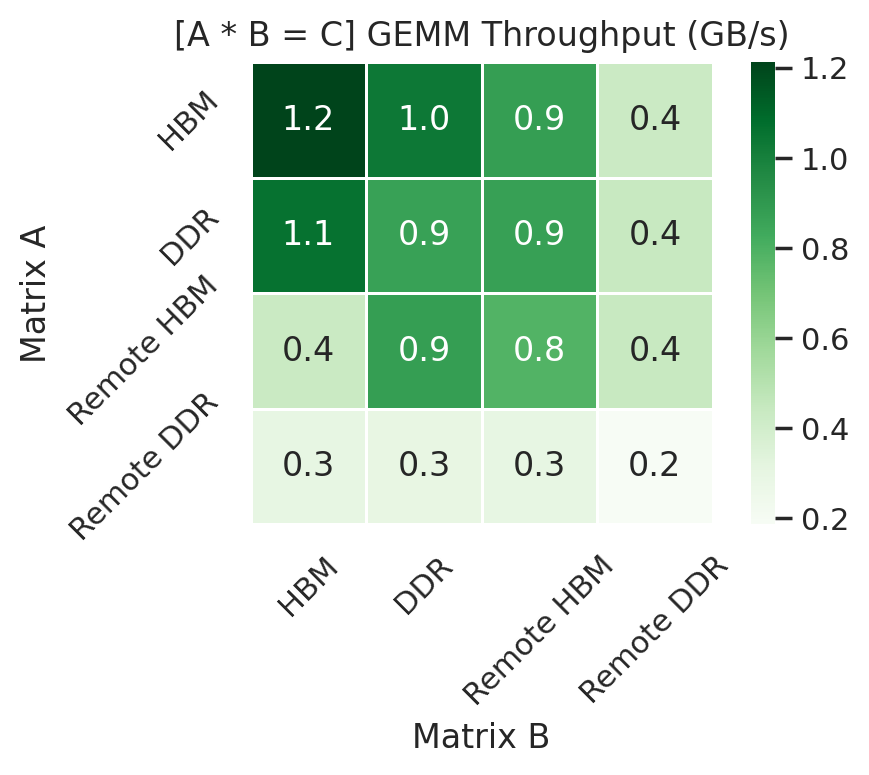

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig.set_dpi(200)
make_gemm_heatmap(ax, 'results/apps/gemm/cublas/', "[A * B = C] GEMM Throughput (GB/s)", 'hbm')

In [1]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig.set_dpi(100)
make_gemm_heatmap(ax, 'results/apps/gemm/openblas/', "[A * B = C] GEMM Throughput (GB/s)", 'ddr')
#make_gemm_heatmap(ax2, 'results/apps/gemm/cublas/', "[A * B = C] GEMM Throughput (GB/s), to ddr_remote", 'ddr_remote')

NameError: name 'plt' is not defined

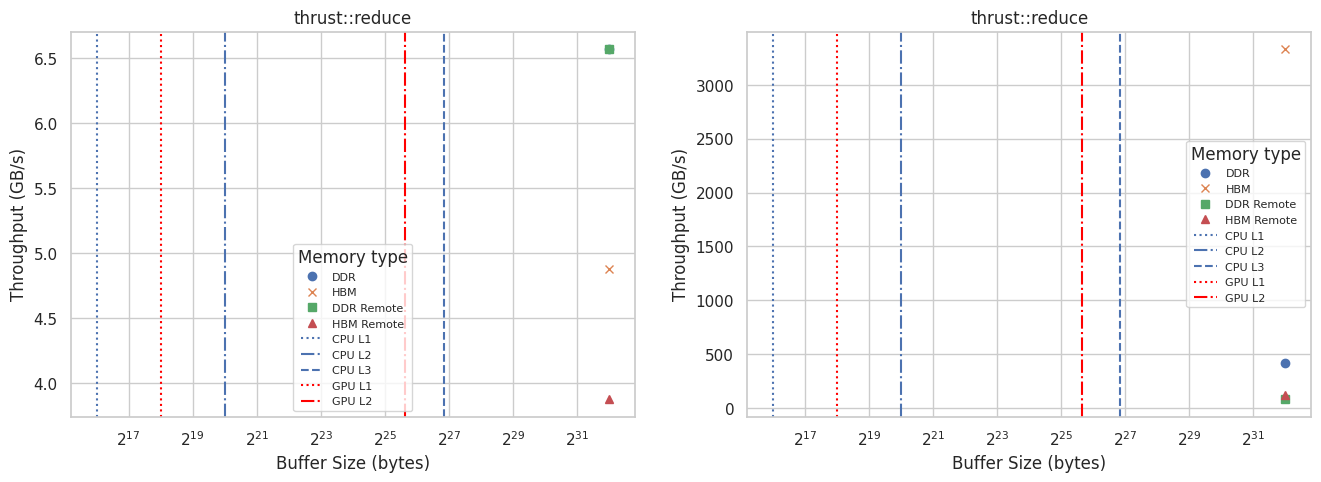

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
make_read_write_graph(ax1, 'results/apps/reduce/host', 'thrust::reduce', remote=True)
make_read_write_graph(ax2, 'results/apps/reduce/device', 'thrust::reduce', remote=True)